#### Creating Tokens 

In [1]:
with open("the-verdict.txt", "r", encoding="utf-8") as f : 
    raw_text = f.read() 
print("Total number of character : ", len(raw_text))
print(raw_text[:99])

Total number of character :  20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


#####  Our goal is to tokenize this 20479 characters short story into individual words and special characters that we can then turn into embeddings for llm training 

In [2]:
import re 
text = "Hello, world. this, is a test" 
res = re.split(r'(\s)', text )
print(res)

['Hello,', ' ', 'world.', ' ', 'this,', ' ', 'is', ' ', 'a', ' ', 'test']


In [3]:
## we also need , . to be spereate 
res = re.split(r'([,.]|\s)', text)
print(res)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'this', ',', '', ' ', 'is', ' ', 'a', ' ', 'test']


In [4]:
### removeing the white space characters 
res = [item for item in res if item.strip()]
print(res)

['Hello', ',', 'world', '.', 'this', ',', 'is', 'a', 'test']


In [5]:
test = "Hello, world. Is this -- a test ?"
result = re.split(r'([,.:;?_!"()\']|--|\s)', test)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


##### Now lets apply in our main dataset raw_text

In [6]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [7]:
len(preprocessed)

4690

#### Creating Token id's 

In [8]:
all_words = sorted(set(preprocessed)) ## unique and sorted
vocab_size = len(all_words)  # only unique words 
print(vocab_size)

1130


In [9]:
vocab = {token : integer for integer,token in enumerate(all_words)}

In [10]:
for i , item in enumerate(vocab.items()): 
    print(item)
    if i >= 50: 
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


#### Lets implement a Tokeninzer Class in python  
* Encode method :- sample text -> tokenized text -> token ids 
* Decode method :- token ids -> tokenized test -> sample text 

In [11]:
class SimpleTokenizerV1: 
    def __init__(self, vocab): 
        self.str_to_int = vocab 
        self.int_to_str = {i:s for s,i in vocab.items()}
    def encode(self, text): 
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids 
    def decode(self, ids): 
        text = " ".join([self.int_to_str[i] for i in ids]) 
        # replace spaces before the specifed punctuation 
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [12]:
tokenizer = SimpleTokenizerV1(vocab)
text = """"It's the last he painted, you know," 
        Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text) 
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


In [13]:
tokenizer.decode(ids) 

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

In [14]:
### there is one promblem that if the text is not present int the vocab then it will throw error to us 

#### Special Context Tokens  : 
* In this section , we will modify the tokenizer to handle unknow words
* In particular , we will modify the vocab and tokenizer we implemented in the previous section , tokenizerv2 to support two new tokens, <|unk|> and <|endoftext|>

In [15]:
all_tokens = sorted(set(preprocessed))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
vocab = {token : integer for integer,token in enumerate(all_tokens)}

In [16]:
len(vocab.items())

1132

In [17]:
for i , item in enumerate(list(vocab.items()) [-5:]): 
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


In [18]:
class SimpleTokenizerV2:   ## V2 
    def __init__(self, vocab): 
        self.str_to_int = vocab 
        self.int_to_str = {i:s for s,i in vocab.items()}
        
    def encode(self, text): 
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
                item if item in self.str_to_int
                else "<|unk|>"
                for item in preprocessed
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids 
    def decode(self, ids): 
        text = " ".join([self.int_to_str[i] for i in ids]) 
        # replace spaces before the specifed punctuation 
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [19]:
tokenizer = SimpleTokenizerV2(vocab)
text1 = "Hello , do you like tea ?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1,text2))
print(text)

Hello , do you like tea ? <|endoftext|> In the sunlit terraces of the palace.


In [20]:
tokenizer.encode(text)

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]

In [21]:
### above 1131 is an unk text and in 1130 is the endoftext

In [22]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.'

#### BYTE PAIR ENCODING 
* This Section covers a more sophisticated tokenization scheme based on a concpet called byte pair encoding (BPE).
* The BPE tokenizer covered in this section is used to train LLMs such as GPT-3 , GPT-2 and the orginal models used in ChatGpt.

##### Since implementing BPE can be relatively 

In [27]:
tokenizer = tiktoken.get_encoding("gpt2")
tokenizer.n_vocab

50257

In [28]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces "
    "of someunkownPlace."
)

integers = tokenizer.encode(
    text,
    allowed_special={"<|endoftext|>"}
)
print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 2954, 593, 27271, 13]


In [29]:
Strings = tokenizer.decode(integers)
print(Strings)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunkownPlace.


#### CREATING INPUT-TARGET PAIR

##### In this section we implement a data loader that fetches the input-target pair using a sliding window apporach. 

In [5]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

with open("the-verdict.txt", "r", encoding="utf-8") as f : 
    raw_text = f.read()
enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


In [31]:
# Creating an a sample_text 
enc_sample = enc_text[50:]

##### One of the easiest and most intuitive ways to create the input-target pairs for the nextword prediction task 
##### is to create x as input tokens and y as a targets , which input shifts by 1 . 

and the context size determines how many tokens are included in the input 

In [32]:
context_size = 4 # length of the input 
# the context_size of 4 means that the model is trained to look at a sequence of 4 words (or tokens)
# to predict the next word in the sequence . 
# the input x is the first 4 tokens [1,2,3,4] and the target y is the next 4 tokens [2,3,4,5]

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x : {x}")
print(f"y : {y}")

x : [290, 4920, 2241, 287]
y : [4920, 2241, 287, 257]


In [33]:
for i in range(1, context_size+1): 
    context = enc_sample[:i] 
    desired = enc_sample[i]
    print(context, "----->", desired)

[290] -----> 4920
[290, 4920] -----> 2241
[290, 4920, 2241] -----> 287
[290, 4920, 2241, 287] -----> 257


In [34]:
for i in range(1, context_size+1): 
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "----->", tokenizer.decode([desired]))

 and ----->  established
 and established ----->  himself
 and established himself ----->  in
 and established himself in ----->  a


##### There's only one more task before we can turn the tokens into embeddings : implementing an efficient data loader that iterates 
##### over the input dataset and returns the inputs and targets as PyTorch tensors, which can be thought as multidimensional arrays . 

* In particularly, we are interested in returning two tensors . an input tensor containing the text that the LLM sees and a target tensor that includes
  the targets for the LLM to predict. 

#### IMPLEMENTING AN A DATA LOADER 
* 1. Tokenize the entire text
  2. Use a sliding window to chunk the book into overlapping sequence of max_length
  3. Return the total number of rows in the dataset
  4. Return a single row from the dataset 

In [1]:
from torch.utils.data import Dataset, DataLoader 

class GPTDatasetV1(Dataset): 

    def __init__(self, txt, tokenizer, max_length, stride): 
        
        self.input_ids = []
        self.target_ids = [] 
        
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        for i in range(0, len(token_ids)- max_length, stride): 
            
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self): 
        return len(self.input_ids)

    def __getitem__(self, idx): 
        return self.input_ids[idx], self.target_ids[idx] 
    

##### The following code will use the GPTdatasetV1 to load the inputs in batches via a pytorch DataLoader: 

##### 
* 1. Initialize the tokenizer
  2. Create dataset
  3. drop_last = true drops the last batch if it is shorter than the specified batch_size to prevent losss spikes during training
  4. the number of CPU processes to use for preprocessing 

In [2]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride = 128,
                         shuffle=True, drop_last = True,
                         num_workers=0): 
    tokenizer = tiktoken.get_encoding("gpt2")

    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
        drop_last=drop_last, 
        num_workers=num_workers 
    )
    return dataloader

In [3]:
with open("the-verdict.txt", "r", encoding="utf-8") as f : 
    raw_text = f.read() 

In [6]:
import torch 
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print("Pytorch version:", torch.__version__)

dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)

print(first_batch)

Pytorch version: 2.9.1+cpu
[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [7]:
####  firt_batch have two tensors input and the target 
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


In [8]:
### exprement batch size 8 
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n" , inputs)
print("Targets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


#### CREATING TOKEN EMBEDDINGS

In [9]:
### example 
input_ids = torch.tensor([2,3,5,1])

In [10]:
### lets assume for now 6 words are there and vector dim is 3 
vocab_size = 6 
vector_dim = 3 

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, vector_dim)  ## just an lookup embedding layer

In [11]:
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [12]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


In [13]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


#### POSITIONAL EMBEDDING

In [14]:
vocab_size = 50257
ouput_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size,ouput_dim)


In [15]:
max_length = 4 
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length, 
    stride=max_length, shuffle=False
)

data_iter = iter(dataloader)
inputs, target = next(data_iter)

In [16]:
print("Inputs:\n" , inputs)
print("\nShape of the input:\n", inputs.shape)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Shape of the input:
 torch.Size([8, 4])


##### Now lets just use the embedding layer to convert this inputs ids into 256 dim vectors 

In [17]:
token_embedding = token_embedding_layer(inputs)
print(token_embedding.shape)

torch.Size([8, 4, 256])


##### For a GPT models absolute embedding approch , we just need to create another embedding layer that as 
the dim as the token 

In [18]:
context_length = max_length 
poss_embedding_layer = torch.nn.Embedding(context_length, ouput_dim)

In [19]:
poss_embedding = poss_embedding_layer(torch.arange(max_length))
print(poss_embedding.shape)

torch.Size([4, 256])


In [20]:
input_embedding = token_embedding + poss_embedding 

In [21]:
print(input_embedding[0][1])

tensor([ 2.0903, -0.4664, -0.0593,  0.3280, -1.8009,  0.5486, -2.8841, -0.4115,
        -0.1192, -0.4399, -0.9973, -0.8983,  1.2419,  0.3530, -1.1971,  2.3292,
        -0.1062, -1.4586,  0.0193, -0.3359,  1.6694, -0.0300,  0.7533,  1.2693,
         0.7280, -0.4353,  1.0748,  1.8392,  0.2908, -1.0326,  1.6424, -2.0670,
         0.6067, -0.0350, -5.3586, -1.0983, -1.3643,  3.3477, -2.2081,  1.1515,
        -0.4515, -0.5733, -0.2321,  1.0255,  1.1737,  0.2789,  0.1338, -1.8594,
         0.8700, -1.7540, -0.8031, -0.4654, -1.5357,  0.3671,  1.9353,  1.0092,
         2.0086,  0.1679,  2.3534, -1.6466,  0.5797, -0.3691,  0.1013, -1.2863,
        -1.8847,  2.9652,  0.7039,  2.4139,  0.5295,  1.0999, -0.7143,  3.0337,
         0.8261,  1.5616,  2.0337, -1.4351,  0.4047,  0.2665, -1.4885, -1.0795,
        -0.5672,  2.0462,  0.6691, -0.1792,  1.0199, -1.1767,  3.8397,  3.2817,
        -1.1248,  2.0827,  0.0650, -0.6966, -1.3178, -0.0903, -3.2958,  1.4560,
        -0.9442,  0.1773, -0.3239, -0.05

##### 
    token_embedding[0][1]   # meaning of the word
    + pos_embedding[1]      # position = 1 (second word)


#### SELF ATTENTION 

##### Simplified self attention mechanism 

we are going to consider input sentence which has already been embedded as into 3-dim vectors . 
we choose a small embedding dim for understanding 

In [1]:
import torch 

inputs = torch.tensor(
    [[0.43, 0.15, 0.89],  # Your  x1
     [0.55, 0.87, 0.66],  # journey x2
     [0.57, 0.85, 0.64],  # starts  x3 
     [0.22, 0.58, 0.33],  # with x4 
     [0.77, 0.25, 0.10],  # one x5 
     [0.05, 0.80, 0.55]]  # step x6 
)

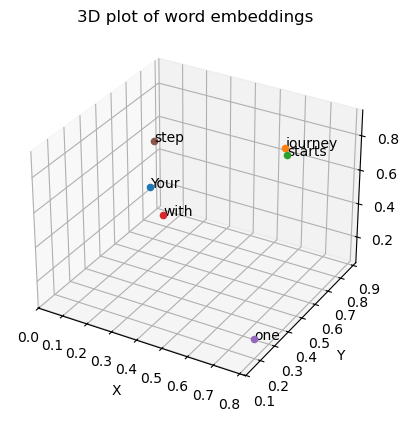

In [2]:
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

words = ['Your', 'journey', 'starts', 'with', 'one', 'step']

x_coords = inputs[:, 0].numpy()
y_coords = inputs[:, 1].numpy()
z_coords = inputs[:, 2].numpy() 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for x, y, z, word in zip(x_coords, y_coords, z_coords, words): 
    ax.scatter(x,y,z)
    ax.text(x,y,z,word, fontsize=10)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D plot of word embeddings')
plt.show()

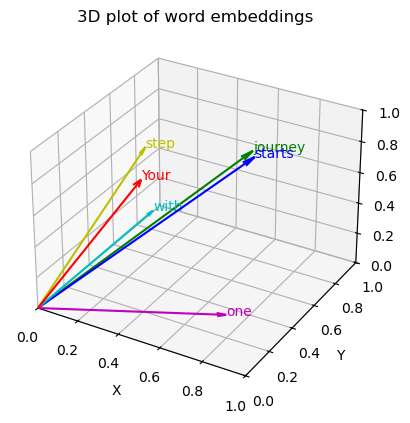

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b', 'c', 'm', 'y']

for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words, colors): 
    ax.quiver(0,0,0,x,y,z,color=color,arrow_length_ratio=0.05)
    ax.text(x,y,z,word,fontsize=10,color=color)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_zlim([0,1])

plt.title('3D plot of word embeddings')
plt.show()

In [4]:
query = inputs[1] ## lets just take the 2nd input token as a query which is journey

attn_score_2 = torch.empty(inputs.shape[0])
for i , x_i in enumerate(inputs) : 
    attn_score_2[i] = torch.dot(x_i, query) # dot product 
print(attn_score_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [5]:
attn_score = torch.empty(inputs.shape[0], inputs.shape[0])

for i, query in enumerate(inputs):        # each token as QUERY
    for j, x_i in enumerate(inputs):      # each token as KEY
        attn_score[i, j] = torch.dot(query, x_i)

print(attn_score)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


##### In the next step, we normalize each of the attention scores that we computed previous 

The main goal behind the normalization is to obtain attention weights that sum up to 1. 
This normalization is a convention that is usefull for interpretation and for maintaing training stability 
in an LLM . 

In [6]:
attn_weigh_2_tmp = attn_score_2 / attn_score_2.sum()
print("Attention weights : ", attn_weigh_2_tmp)
print("sum : " , attn_weigh_2_tmp.sum())

Attention weights :  tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
sum :  tensor(1.0000)


##### In practice, its more common and advisiable to use the softmax function for normilization . 


In [7]:
def softmax_naive(x): 
    return torch.exp(x)  / torch.exp(x).sum(dim = 0) 

attn_weigh_2_naive = softmax_naive(attn_score_2)

print("Attention weight : " , attn_weigh_2_naive)
print("Sum : " , attn_weigh_2_naive.sum())

Attention weight :  tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum :  tensor(1.)


In [8]:
## we have pytorch softmax 

attn_weight_2 = torch.softmax(attn_score_2, dim=0)
print("Attention weight : " , attn_weight_2)
print("Sum : " , attn_weight_2.sum())


Attention weight :  tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum :  tensor(1.)


##### Context vector cals 

In [9]:
query = inputs[1] #2nd input token is the query 

context_vec_2 = torch.zeros(query.shape)
for i , x_i in enumerate(inputs): 
    context_vec_2+= attn_weight_2[i] * x_i
print(context_vec_2)


tensor([0.4419, 0.6515, 0.5683])


##### Now we extend this computation for all the embedding inputs 
-> attn score
-> attn weight 
-> context vector 

In [10]:
attn_score = torch.empty(inputs.shape[0], inputs.shape[0])

for i, query in enumerate(inputs):        # each token as QUERY
    for j, x_i in enumerate(inputs):      # each token as KEY
        attn_score[i, j] = torch.dot(query, x_i)

print(attn_score)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


##### Each element in the preceding tensor represents an attention score between each pair of inputs. 

##### When computing the preceding attention score tensor, we used for-loops in Python. 
##### However, for-loops are generally slow, and we can achive the same results using matrix multiplication. 

In [11]:
attn_score = inputs @ inputs.T 
print(attn_score)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


##### We now normilize each row so that the values in each row sum to 1 . (softmax) 

In [12]:
attn_weights = torch.softmax(attn_score, dim=-1) ## we saying to softmax apply this softmax func throught last dim of the matrix
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


##### We now can caluculate the context vector 

In [13]:
context_vector = attn_weights @ inputs  
print(context_vector)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


In [14]:
print(context_vector[1])

tensor([0.4419, 0.6515, 0.5683])


#### IMPLEMENTING SELF ATTENTION MECHANISM FROM TRAINABLE WEIGTHS 

In [2]:
import torch 

inputs = torch.tensor(
    [[0.43, 0.15, 0.89],  # Your  x1
     [0.55, 0.87, 0.66],  # journey x2
     [0.57, 0.85, 0.64],  # starts  x3 
     [0.22, 0.58, 0.33],  # with x4 
     [0.77, 0.25, 0.10],  # one x5 
     [0.05, 0.80, 0.55]]  # step x6 
)

In [3]:
### initializxing some variables for dim 

x_2 = inputs[1] #A   jorney 
d_in = inputs.shape[1] #C
d_out = 2 #C

##### we will initialize the three weights Wq , Wk, Wv

In [4]:
torch.manual_seed(123) 
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [5]:
print(W_query)
print(W_key)
print(W_value)

Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]])
Parameter containing:
tensor([[0.1366, 0.1025],
        [0.1841, 0.7264],
        [0.3153, 0.6871]])
Parameter containing:
tensor([[0.0756, 0.1966],
        [0.3164, 0.4017],
        [0.1186, 0.8274]])


In [6]:
### lets take one example and generate "JOURNEy" 

query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

In [7]:
query_2

tensor([0.4306, 1.4551])

In [8]:
### lets cals all the inputs 
queries, keys, values = inputs @ W_query , inputs @ W_key, inputs @ W_value

##### lets calculate attention score for jorney whcih is w22 

In [9]:
keys_2 = keys[1] #journey key 
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


##### Again we can generalize this computation to all attention scores via matrix multiplication 

In [10]:
attn_score_2 = query_2 @ keys.T 
print(attn_score_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


In [11]:
attn_score = queries @ keys.T 
attn_score

tensor([[0.9231, 1.3545, 1.3241, 0.7910, 0.4032, 1.1330],
        [1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440],
        [1.2544, 1.8284, 1.7877, 1.0654, 0.5508, 1.5238],
        [0.6973, 1.0167, 0.9941, 0.5925, 0.3061, 0.8475],
        [0.6114, 0.8819, 0.8626, 0.5121, 0.2707, 0.7307],
        [0.8995, 1.3165, 1.2871, 0.7682, 0.3937, 1.0996]])

##### we compute the attn weights by scaling the attn scores and using the softmax function we used earlier . 
the difference to earlier is that now , scale the attn score by divding them by the square root of the embedding dim. 
of the keys (2) 

In [12]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_score_2/ d_k**0.5, dim=-1)
print(attn_weights_2)
print(d_k)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])
2


##### WHY divide by sqrt (dim) 

reason1 :- for stability in learning   like to avoid peaky values softmax often produce peaky values 
reason2 :- to make the vairance of the dot product stable (spreading increase) soo by sqt will be close to 1. 

##### Now lets compute context vector 

In [13]:
attn_weights = torch.softmax(attn_score/d_k**0.5, dim = -1)
print(attn_weights)

tensor([[0.1551, 0.2104, 0.2059, 0.1413, 0.1074, 0.1799],
        [0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820],
        [0.1503, 0.2256, 0.2192, 0.1315, 0.0914, 0.1819],
        [0.1591, 0.1994, 0.1962, 0.1477, 0.1206, 0.1769],
        [0.1610, 0.1949, 0.1923, 0.1501, 0.1265, 0.1752],
        [0.1557, 0.2092, 0.2048, 0.1419, 0.1089, 0.1794]])


In [14]:
context_vec_2  = attn_weights_2 @ values
print(context_vec_2)   ## only for context_vec_2 which is journey 

tensor([0.3061, 0.8210])


##### 
<div style = "color :  red"> 
    IMPLEMENTING SELF ATTENTION PYTHON CLASS
</div>

In [15]:
import torch.nn as nn 

class SelfAttention_v1(nn.Module): 

    def __init__ (self, d_in, d_out): 
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):  
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value

        attn_score = queries @ keys.T 
        attn_weights = torch.softmax(attn_score/keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec


    In this pytroch code, selfattention_v1 is a class dervied from nn.Module which is a fundamental building block of 
    pytorch module , which provides neccessary functionalities for model layer creation and mangaemnet


In [16]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))  ## returns the context vector for all the i/ps 

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


In [17]:
## advancement using Linear 
import torch
import torch.nn as nn

class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()

        self.W_query = nn.Linear(d_in, d_out, bias=False)
        self.W_key   = nn.Linear(d_in, d_out, bias=False)
        self.W_value = nn.Linear(d_in, d_out, bias=False)

    def forward(self, x):
        # x: (seq_len, d_in)

        queries = self.W_query(x)   # (seq_len, d_out)
        keys    = self.W_key(x)     # (seq_len, d_out)
        values  = self.W_value(x)   # (seq_len, d_out)

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(
            attn_scores / (keys.shape[-1] ** 0.5),
            dim=-1
        )

        context_vec = attn_weights @ values
        return context_vec

In [18]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))  ## returns the context vector for all the i/ps 

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


##### 
<div style = "color :  yellow" > 
    CAUSAL SELF ATTENTION 
</div>
when computing attention score the causal attention mechanism ensures that the model only factors in token that occur at
or before the current token in the sequence. 

In [19]:
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_score = queries @ keys.T
attn_weights = torch.softmax(attn_score/keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


##### we can use pytorch trill function to create a mask where the values above the dig are zero 

In [20]:
context_length = attn_score.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [21]:
## now we can multiply this with attn_weights 
masked_simple = attn_weights * mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


In [22]:
attn_score

tensor([[ 0.2899,  0.0716,  0.0760, -0.0138,  0.1344, -0.0511],
        [ 0.4656,  0.1723,  0.1751,  0.0259,  0.1771,  0.0085],
        [ 0.4594,  0.1703,  0.1731,  0.0259,  0.1745,  0.0090],
        [ 0.2642,  0.1024,  0.1036,  0.0186,  0.0973,  0.0122],
        [ 0.2183,  0.0874,  0.0882,  0.0177,  0.0786,  0.0144],
        [ 0.3408,  0.1270,  0.1290,  0.0198,  0.1290,  0.0078]],
       grad_fn=<MmBackward0>)

##### Effiecent way to do this is to take the inf of utm matrix 
attn socre -> utm infiinte mask -> softmax

In [23]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal = 1)
masked = attn_score.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [24]:
## now lets do the softmax function to all masked results, and we are done 

attn_weights = torch.softmax(masked/keys.shape[-1]**0.5, dim = -1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [25]:
## we can see above each row are sum up to 1 . causal attention mech is satfified and there is no data leakageabs

##### MASKING ADDITONAL ATTENTION WEIGHTS WITH DROPOUT

##### In the following code example, we use a dropout rate of 50% , which means masking out half of the attention 
weights. when we trian the GPT model in later chapters, we will use a lower dropout rate, such as 0.1, 0.2 .

In [26]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones(6,6)
print(dropout(example))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


In [27]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)


##### IMPLEMENTING CAUSAL ATTENTION CLASS

In [28]:
batch = torch.stack((inputs, inputs) , dim = 0)
print(batch.shape)

torch.Size([2, 6, 3])


In [29]:
class CausalAttention(nn.Module): 
    def __init__(self, d_int, d_out, context_length, dropout, qkv_bias = False): 
        super().__init__() 
        self.d_out = d_out 
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal = 1))

    def forward(self, x): 
        b, num_tokens, d_int = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_score = queries @ keys.transpose(1,2)
        attn_score.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        )
        attn_weights = torch.softmax(attn_score / keys.shape[-1] ** 0.5, dim = -1)
        attn_weights = self.dropout(attn_weights)
        context_vec  = attn_weights @ values
        return context_vec

In [30]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vec = ca(batch)
print("Context_ves.shape : " , context_vec.shape)

Context_ves.shape :  torch.Size([2, 6, 2])


In [31]:
context_vec   

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)

##### 
<div style = "color : yellow">
    MULTI-HEAD ATTENTIONS 
</div>

Creating multiple instance of causual attention 

In [32]:
class MultiHeadAttentionWrapper(nn.Module): 

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False) : 
        super().__init__() 
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias)
            for _ in range(num_heads)]
        )

    def forward(self, x):  
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [33]:
batch = torch.stack((inputs, inputs) , dim = 0)
torch.manual_seed(123)
context_length = batch.shape[1]
d_in, d_out = 3, 2 
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print(context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
torch.Size([2, 6, 4])


##### 
<div style = "color : yellow">
    MULTI-HEAD ATTENTIONS  WITH SPLIT WEIGHTS
</div>

In [36]:
class MultiHeadAttention(nn.Module): 
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):  
        super.__init__()

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match the desired op dim 
        
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_Key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_in) # Linear layer to combine head op 
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask", 
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )


    def forward(self, x):  
        b , num_tokens , d_in = x.shape

        keys  = self.W_Key(x)
        queries = self.W_query(x) #shape (b, num_tokens, d_out)
        values = self.W_value(x)

        # we implicitly split the matrix by adding a num_heads dim 
        # Unroll last dim : (b, num_tokens, d_out) -> (b, num_tokens , num_heads, head_dim)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, selff.head_dim)
        
        # tranpose : (b, num_tokens, num_heads, num_dim) -> (b, num_head, num_tokens, num_dim)

        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        queries = queries.transpose(1, 2)

        # calucalton of attn_score 
        attn_scores = queries @ keys.transpose(2, 3) # dot product for head 
        # orginal mask  truncated to the number of tokens and converted to boolean 
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        # use the mask to fill attention scores 
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        # attn_weights cals 

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5 , dim=-1)  #keys.shape[-1] = head_dim 
        attn_weights = self.dropout(attn_weights)

        # context vector  
        context_vec = (attn_weights @ values).transpose(1,2)

        # combine heads , where self.d_out = self.num_heads * self.head_dim 

        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optimal projection 

        return context_vec        

        

In [37]:
torch.manual_seed(123)

#Define the tensor with 3 rows and 6 colmns 

inputs = torch.tensor(
    [[0.43, 0.15, 0.89, 0.55, 0.87, 0.66], 
     [0.57, 0.85, 0.64, 0.22, 0.58, 0.33], 
     [0.77, 0.25, 0.10, 0.05, 0.80, 0.55]
    ]
)

batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

batch_size , context_length , d_in = batch.shape
d_out = 6
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vec = mha(batch)
print(context_vec)
print("context_vec shape", context_vec.shape)

torch.Size([2, 3, 6])


TypeError: descriptor '__init__' of 'super' object needs an argument